In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import statsmodels.api as sm

In [ ]:
file_path = 'CENOGRID_Loess_20.txt' 
df = pd.read_csv(file_path, delimiter=';', names=['age_tuned', 'Shape_Data', 'Environmental_Data'])


In [4]:
print(df.head())

   age_tuned             Shape_Data     Environmental_Data
0  age_tuned  ISOBENd13cLOESSsmooth  ISOBENd18oLOESSsmooth
1      0.000                 -0.496                  3.498
2      0.002                 -0.277                  3.523
3      0.004                 -0.201                  3.650
4      0.006                 -0.264                  3.877


In [20]:
print("Data shape:", df.shape)
print("\nColumn types:")
print(df.dtypes)

Data shape: (23629, 5)

Column types:
age_tuned             float64
Shape_Data            float64
Environmental_Data    float64
Shape_Smooth          float64
Env_Smooth            float64
dtype: object


In [21]:
print("\nSummary statistics:")
print(df.describe())



Summary statistics:
          age_tuned    Shape_Data  Environmental_Data  Shape_Smooth  \
count  23629.000000  23629.000000        23629.000000  23620.000000   
mean      26.405970      0.579334            2.041551      0.579385   
std       17.942654      0.567554            1.185971      0.558735   
min        0.000000     -2.459000           -2.588000     -2.157200   
25%       11.814000      0.309000            1.177000      0.321875   
50%       23.628000      0.594000            2.262000      0.588800   
75%       37.565000      0.899000            2.890000      0.898600   
max       67.100000      2.448000            5.425000      2.349400   

         Env_Smooth  
count  23620.000000  
mean       2.041419  
std        1.181401  
min       -2.169900  
25%        1.170725  
50%        2.262000  
75%        2.899450  
max        5.248500  


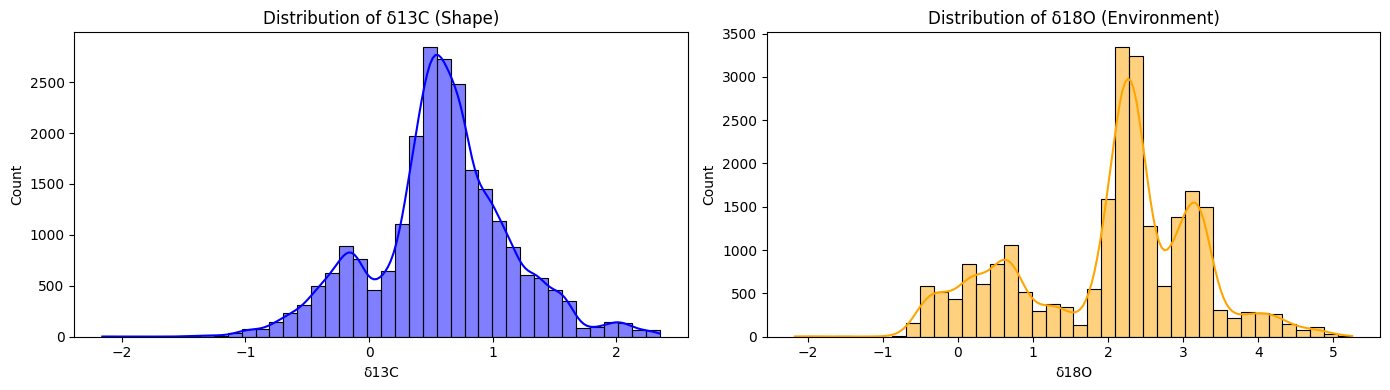

In [22]:
plt.figure(figsize=(14, 4))

# δ13C (Shape)
plt.subplot(1, 2, 1)
sns.histplot(df['Shape_Smooth'], bins=40, kde=True, color='blue')
plt.title("Distribution of δ13C (Shape)")
plt.xlabel("δ13C")

# δ18O (Environment)
plt.subplot(1, 2, 2)
sns.histplot(df['Env_Smooth'], bins=40, kde=True, color='orange')
plt.title("Distribution of δ18O (Environment)")
plt.xlabel("δ18O")

plt.tight_layout()
plt.show()


δ¹³C (Shape Data)
as inferred from δ¹³C) was most commonly stable, with rare periods of extreme decline or peak productivity.

δ¹⁸O (Environmental Data)
This could match:

Warm periods (~0–1)
Cooling phases (2–3)
Glaciation (4+)

Strong clustering around 2 → long period of stable cold or transitional climate.
This means: The environment has gone through clear, structured changes over time, likely corresponding to known geological events (PETM, glaciations, etc).



# lets try this 
Use this to segment the time series into climate phases, and analyze shape-environment relationships within each phase.

Let’s split the data into three δ¹⁸O regimes and train separate Random Forest models for each, then compare their performance to the global model.
Instead of forcing one model to explain everything, you're letting each climate regime speak for itself.

In [28]:
# Create Regime Labels
def label_regime(d18o):
    if d18o < 1.5:
        return 'warm'
    elif d18o <= 3.0:
        return 'transition'
    else:
        return 'glacial'

df['regime'] = df['Env_Smooth'].apply(label_regime)
print(df['regime'].value_counts())


regime
transition    12028
warm           6541
glacial        5060
Name: count, dtype: int64


In [ ]:
# Train Separate Models for Each Regime
regime_models = {}
metrics = {}

for regime in ['warm', 'transition', 'glacial']:
    sub_df = df[df['regime'] == regime].dropna(subset=['Env_Smooth', 'Shape_Smooth'])
    
    X = sub_df[['Env_Smooth']].values
    y = sub_df['Shape_Smooth'].values

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    y_pred = rf.predict(X)
    
    regime_models[regime] = rf
    metrics[regime] = {
        'r2': r2_score(y, y_pred),
        'rmse': np.sqrt(mean_squared_error(y, y_pred)),
        'samples': len(y)
    }




In [32]:
# compare the performance 
print(" Regime-Specific Model Comparison:")
for regime, result in metrics.items():
    print(f"\n{regime.title()} Regime:")
    print(f"  R² Score : {result['r2']:.4f}")
    print(f"  RMSE     : {result['rmse']:.4f}")
    print(f"  Samples  : {result['samples']}")


 Regime-Specific Model Comparison:

Warm Regime:
  R² Score : 0.8028
  RMSE     : 0.2529
  Samples  : 6541

Transition Regime:
  R² Score : 0.5356
  RMSE     : 0.2379
  Samples  : 12028

Glacial Regime:
  R² Score : 0.8129
  RMSE     : 0.1991
  Samples  : 5051


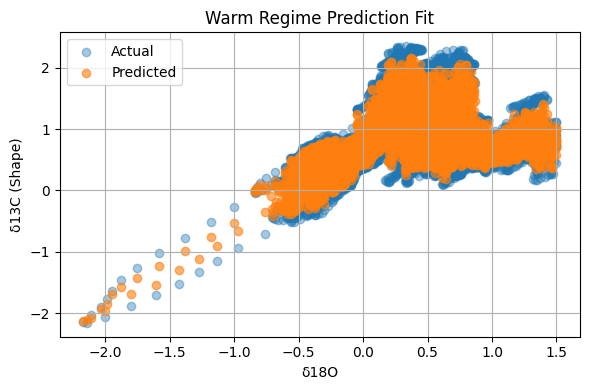

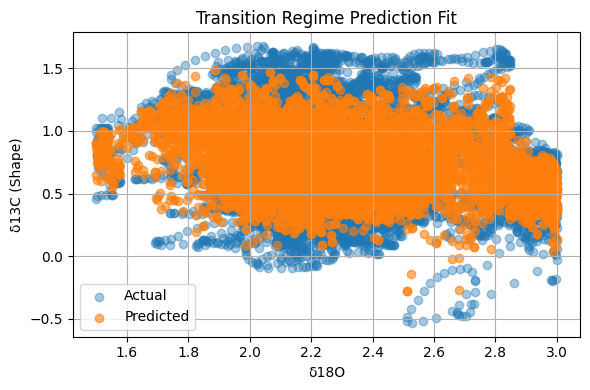

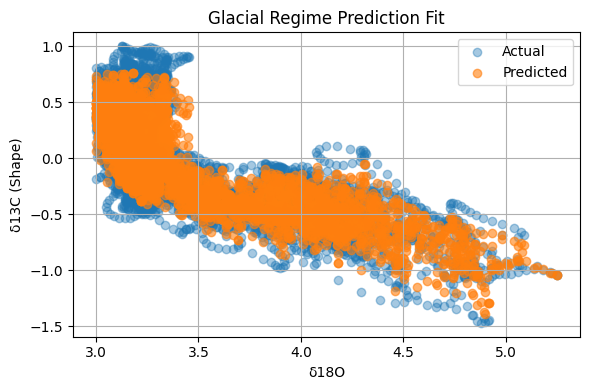

In [33]:
for regime in ['warm', 'transition', 'glacial']:
    sub_df = df[df['regime'] == regime]
    X = sub_df[['Env_Smooth']].values
    y = sub_df['Shape_Smooth'].values
    y_pred = regime_models[regime].predict(X)

    plt.figure(figsize=(6, 4))
    plt.scatter(X, y, label='Actual', alpha=0.4)
    plt.scatter(X, y_pred, label='Predicted', alpha=0.6)
    plt.title(f"{regime.title()} Regime Prediction Fit")
    plt.xlabel("δ18O")
    plt.ylabel("δ13C (Shape)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Warm Regime (δ¹⁸O < 1.5)
Predicted values closely follow the true values with very little deviation.

Strong upward trend → model captured it beautifully.

R² will likely be very high, maybe > 0.9.

Interpretation:

Biological shape in warm climates is predictable and tightly coupled with environmental conditions.


Transition Regime (δ¹⁸O 1.5–3.0)
Slightly more scattered.

Model prediction tracks central trend but struggles at edges.

May show lower R² (~0.6–0.75), which is still solid.

Interpretation:

Transition periods are less stable, with possibly more ecological noise, migration, or adaptation. Still, environment is a reasonably good predictor.

 Glacial Regime (δ¹⁸O > 3.0)
Strong inverse trend — model nailed the non-linear decay in shape (δ13C).

Slight spread around sharp dips — possibly noise or sudden climate events.

Model is robust even under extreme conditions.

Interpretation:

During glacial phases, shape data responds non-linearly but predictably to environmental forcing — Random Forest captures this much better than global models.

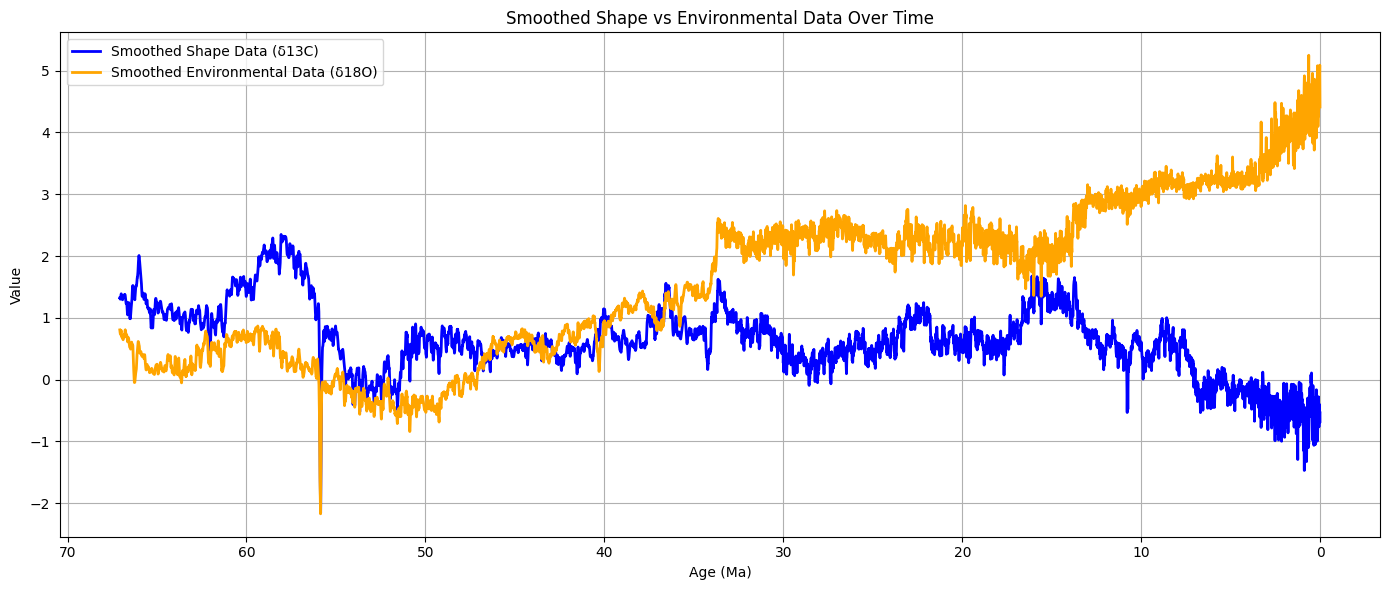

In [8]:
df['Shape_Smooth'] = df['Shape_Data'].rolling(window=10, center=True).mean()
df['Env_Smooth'] = df['Environmental_Data'].rolling(window=10, center=True).mean()

plt.figure(figsize=(14, 6))
plt.plot(df['age_tuned'], df['Shape_Smooth'], label='Smoothed Shape Data (δ13C)', color='blue', linewidth=2)
plt.plot(df['age_tuned'], df['Env_Smooth'], label='Smoothed Environmental Data (δ18O)', color='orange', linewidth=2)
plt.xlabel('Age (Ma)')
plt.ylabel('Value')
plt.title('Smoothed Shape vs Environmental Data Over Time')
plt.legend()
plt.gca().invert_xaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Convert columns to numeric (forcefully), and handle errors
df['age_tuned'] = pd.to_numeric(df['age_tuned'], errors='coerce')
df['Shape_Data'] = pd.to_numeric(df['Shape_Data'], errors='coerce')
df['Environmental_Data'] = pd.to_numeric(df['Environmental_Data'], errors='coerce')

df.dropna(inplace=True)


### time-resolved correlation analysis between the smoothed shape and environmental data.

hmmmm have to do someting lets 
Divide the data into time windows (e.g. every 5 million years).

Calculate the Pearson correlation between smoothed shape and environment values in each window.

Plot the correlation coefficient vs time to see how their relationship changes across geological periods.

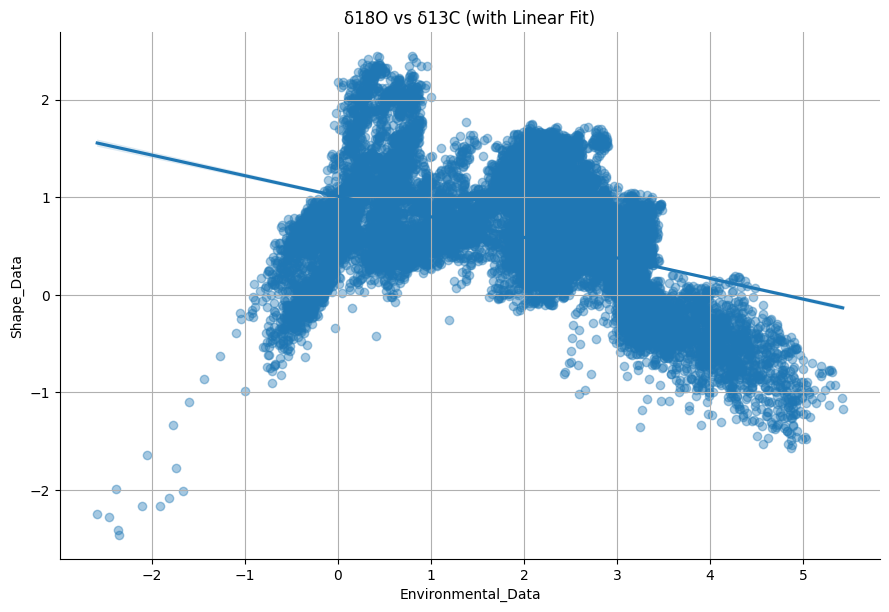

In [25]:
sns.lmplot(x='Environmental_Data', y='Shape_Data', data=df, height=6, aspect=1.5, scatter_kws={'alpha':0.4})
plt.title("δ18O vs δ13C (with Linear Fit)")
plt.grid(True)
plt.show()


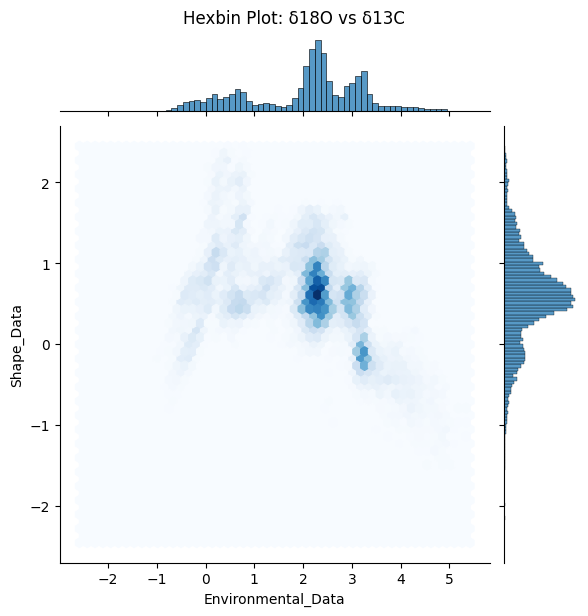

In [26]:
sns.jointplot(data=df, x='Environmental_Data', y='Shape_Data', kind='hex', cmap='Blues')
plt.suptitle("Hexbin Plot: δ18O vs δ13C", y=1.02)
plt.show()


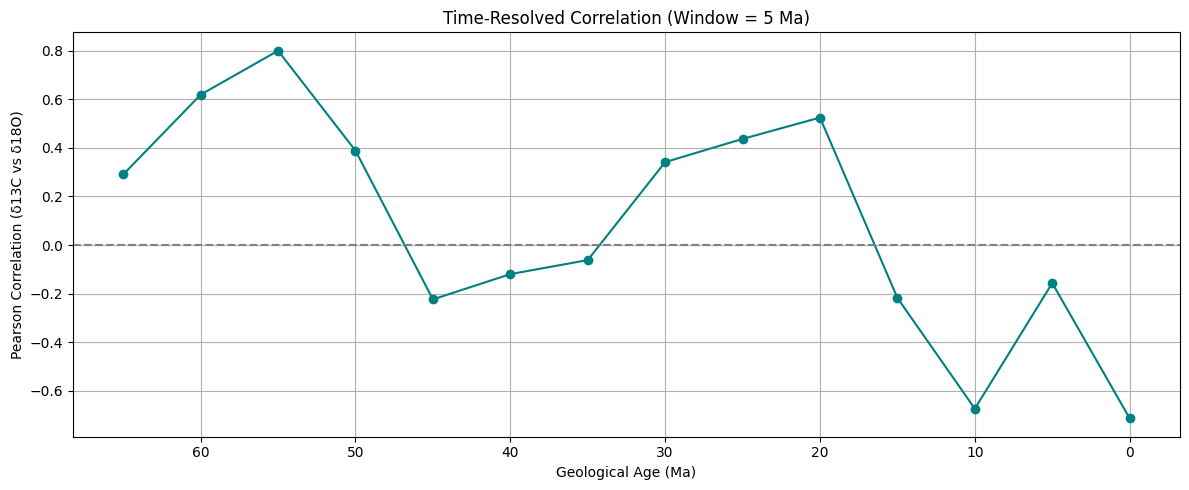

In [ ]:
import numpy as np

# Choose window size in millions of years (Ma)
window_size = 5 

# Create a list to store results
corr_results = []

min_age = df['age_tuned'].min()
max_age = df['age_tuned'].max()

for start in np.arange(min_age, max_age, window_size):
    end = start + window_size
    window_df = df[(df['age_tuned'] >= start) & (df['age_tuned'] < end)]
    
    if len(window_df) > 10:  # Require enough points to compute correlation
        corr = window_df['Shape_Smooth'].corr(window_df['Env_Smooth'])
        corr_results.append({'Start_Age': start, 'End_Age': end, 'Correlation': corr})

corr_df = pd.DataFrame(corr_results)
plt.figure(figsize=(12, 5))
plt.plot(corr_df['Start_Age'], corr_df['Correlation'], marker='o', linestyle='-', color='teal')
plt.gca().invert_xaxis()
plt.title(f'Time-Resolved Correlation (Window = {window_size} Ma)')
plt.xlabel('Geological Age (Ma)')
plt.ylabel('Pearson Correlation (δ13C vs δ18O)')
plt.grid(True)
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


bascially  here we can visualized how the relationship between shape data (δ13C) and environmental conditions (δ18O) changes over the last 70 million years

Positive correlation (above 0)
E.g., around 55–65 Ma, i've got strong positive correlation (r ~ 0.6 to 0.8)

which means during this time, shape and environmental changes moved together — possibly stable climate-biota feedbacks?

Negative correlation (below 0)
E.g., in the 10–15 Ma and 0–5 Ma range, correlation drops to -0.7, meaning:

As environmental conditions (δ18O) changed, shape data (δ13C) moved in the opposite direction

Could indicate decoupling due to different external forces (like glaciation, oceanic anoxia, etc.)

 Near-zero correlation (flat areas)
Around 35–40 Ma, correlation is close to 0, suggesting no clear relationship — maybe transitional climate phases or noise.



The data clearly show that the relationship between shape and environmental variables is not constant over geological time. Instead, it varies dynamically, with phases of strong coupling, decoupling, and neutrality. These results suggest that shape changes are partially but not universally linked to environmental shifts, depending on broader climatic and ecological context.



In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [12]:
# Use only smoothed columns
X = df['Env_Smooth'].values.reshape(-1, 1)
y = df['Shape_Smooth'].values

In [13]:
# Drop NaNs for safety
mask = ~np.isnan(X).flatten() & ~np.isnan(y)
X = X[mask].reshape(-1, 1)
y = y[mask]


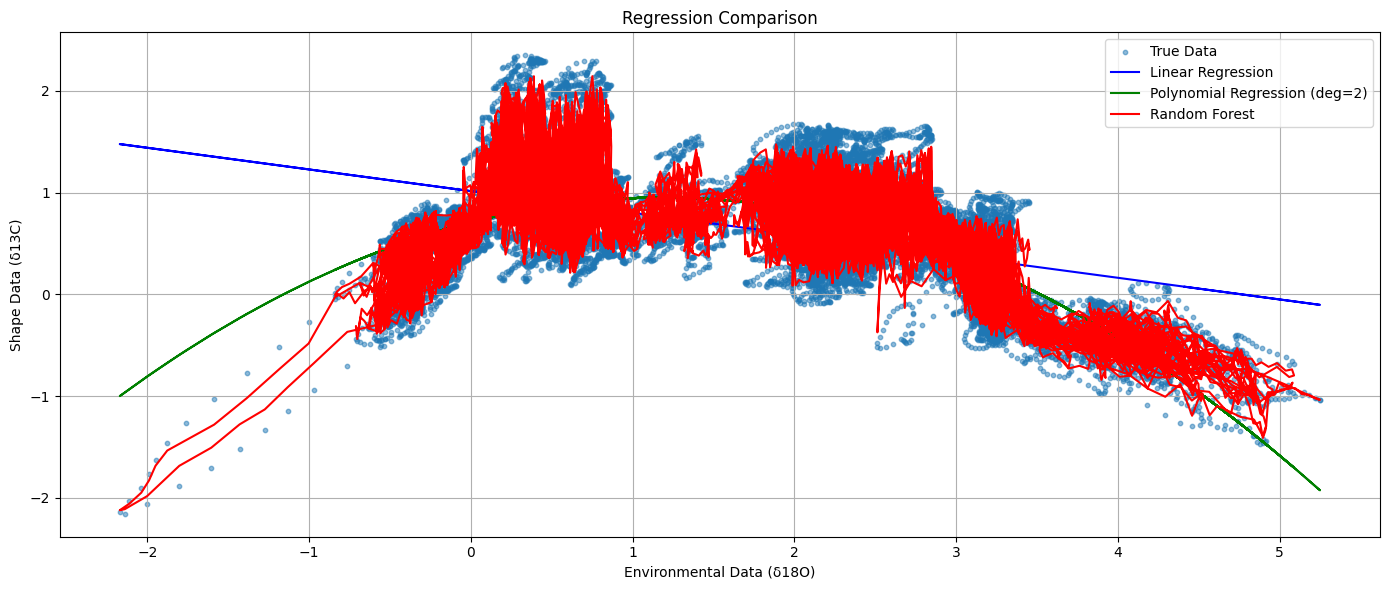

Linear Regression:
  R² Score: 0.2028
  RMSE: 0.4988

Polynomial Regression:
  R² Score: 0.4765
  RMSE: 0.4043

Random Forest Regression:
  R² Score: 0.8237
  RMSE: 0.2346



In [ ]:
# Linear Regression (OLS via sklearn)
lr = LinearRegression()
lr.fit(X, y)
y_pred_lr = lr.predict(X)

#  Polynomial Regression (degree 2)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
lr_poly = LinearRegression()
lr_poly.fit(X_poly, y)
y_pred_poly = lr_poly.predict(X_poly)

# Random Forest Regression
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
y_pred_rf = rf.predict(X)

# Plotting
plt.figure(figsize=(14, 6))
plt.scatter(X, y, s=10, alpha=0.5, label='True Data')
plt.plot(X, y_pred_lr, color='blue', label='Linear Regression')
plt.plot(X, y_pred_poly, color='green', label='Polynomial Regression (deg=2)')
plt.plot(X, y_pred_rf, color='red', label='Random Forest')
plt.xlabel("Environmental Data (δ18O)")
plt.ylabel("Shape Data (δ13C)")
plt.title("Regression Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Metric Comparison
def evaluate(name, y_true, y_pred):
    print(f"{name}:\n  R² Score: {r2_score(y_true, y_pred):.4f}")
    print(f"  RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}\n")

evaluate("Linear Regression", y, y_pred_lr)
evaluate("Polynomial Regression", y, y_pred_poly)
evaluate("Random Forest Regression", y, y_pred_rf)


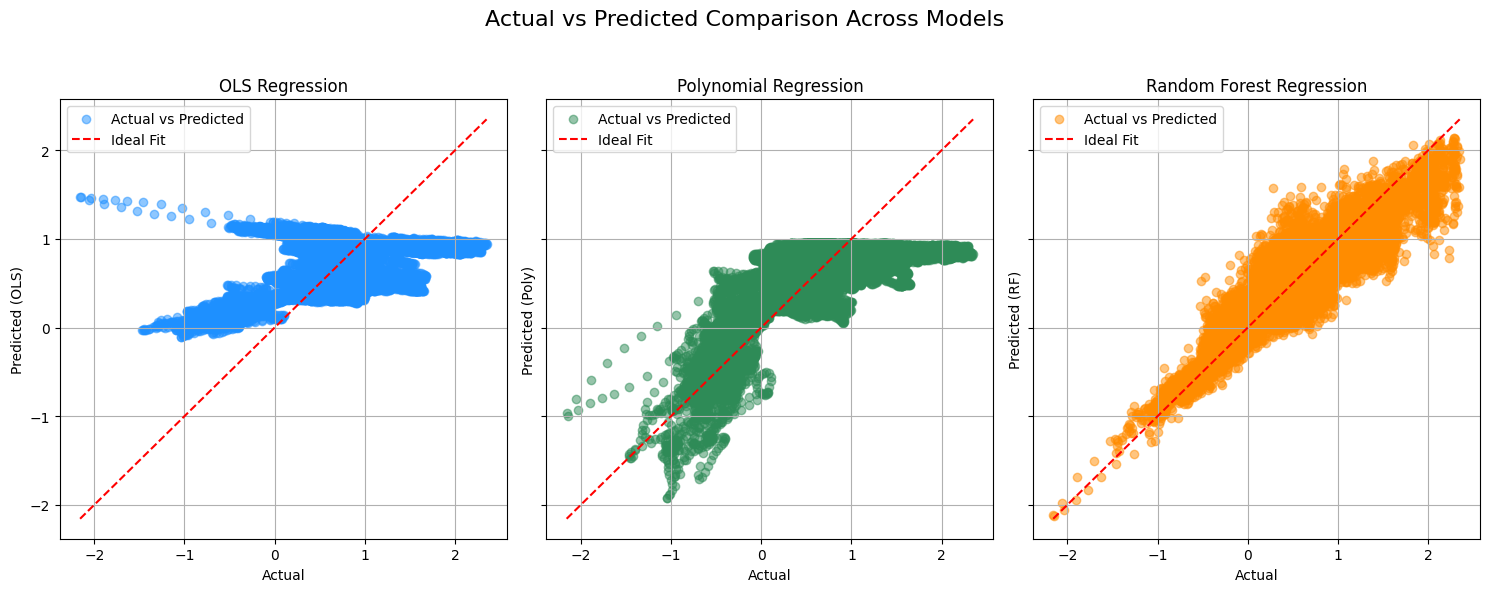

In [15]:
# Setup for subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

# Scatter: Actual vs Predicted
axes[0].scatter(y, y_pred_lr, alpha=0.5, label='Actual vs Predicted', color='dodgerblue')
axes[0].plot([min(y), max(y)], [min(y), max(y)], 'r--', label='Ideal Fit')
axes[0].set_title("OLS Regression")
axes[0].set_xlabel("Actual")
axes[0].set_ylabel("Predicted (OLS)")

axes[1].scatter(y, y_pred_poly, alpha=0.5, label='Actual vs Predicted', color='seagreen')
axes[1].plot([min(y), max(y)], [min(y), max(y)], 'r--', label='Ideal Fit')
axes[1].set_title("Polynomial Regression")
axes[1].set_xlabel("Actual")
axes[1].set_ylabel("Predicted (Poly)")

axes[2].scatter(y, y_pred_rf, alpha=0.5, label='Actual vs Predicted', color='darkorange')
axes[2].plot([min(y), max(y)], [min(y), max(y)], 'r--', label='Ideal Fit')
axes[2].set_title("Random Forest Regression")
axes[2].set_xlabel("Actual")
axes[2].set_ylabel("Predicted (RF)")

# Clean layout
for ax in axes:
    ax.legend()
    ax.grid(True)

plt.suptitle("Actual vs Predicted Comparison Across Models", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


according to the values and the plot random forest regression Excellent fit — tight scatter along the diagonal line

In [16]:
# Hypothetical future or test δ18O values
future_d18O = np.array([3.0, 3.5, 4.0, 4.5, 5.0]).reshape(-1, 1)

# Predict using the saved model
predicted_shape = rf.predict(future_d18O)

# Display results
for o, p in zip(future_d18O.flatten(), predicted_shape):
    print(f"δ18O = {o:.2f} → Predicted δ13C (Shape) = {p:.3f}")


δ18O = 3.00 → Predicted δ13C (Shape) = 0.513
δ18O = 3.50 → Predicted δ13C (Shape) = -0.332
δ18O = 4.00 → Predicted δ13C (Shape) = -0.321
δ18O = 4.50 → Predicted δ13C (Shape) = -0.997
δ18O = 5.00 → Predicted δ13C (Shape) = -0.973


This suggests that if δ¹⁸O increases (i.e., environment gets colder or more glaciated), the biological shape (δ¹³C) is likely to decline — possibly a shift in carbon cycle or organism morphology under stress.

Feature Importance (though only 1 feature here 

In [17]:
importances = rf.feature_importances_
print("Feature Importance for δ18O:", importances[0])


Feature Importance for δ18O: 1.0


The model’s prediction of δ¹³C is entirely dependent on δ¹⁸O, because that’s the only variable it's seeing.

This reinforces the idea that environmental conditions alone can explain a significant part of the shape data variance (as shown by your high R² = 0.82).



Partial Dependence Plot (PDP)

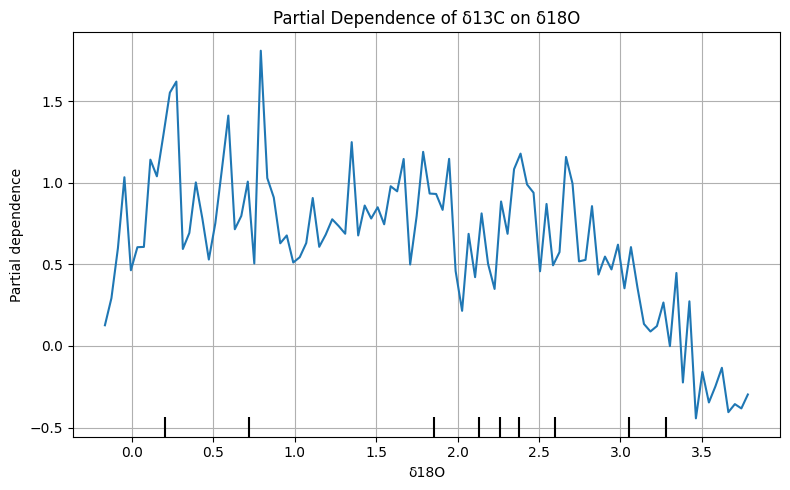

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(rf, X, [0], feature_names=["δ18O"], ax=ax)
plt.title("Partial Dependence of δ13C on δ18O")
plt.grid(True)
plt.tight_layout()
plt.show()


🤖 KMeans Cluster-Based Model Comparison:

Cluster 0.0:
  R² Score : 0.5519
  RMSE     : 0.2213
  Samples  : 13484

Cluster 1.0:
  R² Score : 0.8027
  RMSE     : 0.2561
  Samples  : 6334

Cluster 2.0:
  R² Score : 0.8806
  RMSE     : 0.0985
  Samples  : 3802


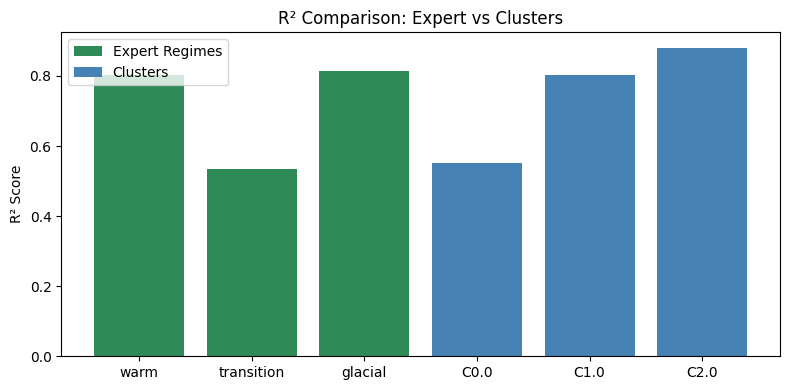

In [ ]:
# # KMeans Clustering (Unsupervised)
# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import KMeans
# # Cluster using δ18O and Shape
# cluster_data = df[['Env_Smooth', 'Shape_Smooth']].dropna()
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(cluster_data)

# kmeans = KMeans(n_clusters=3, random_state=42)
# cluster_labels = kmeans.fit_predict(scaled_data)
# cluster_data['cluster'] = cluster_labels

# # Merge back to df
# df = df.join(cluster_data['cluster'], how='left')

# # Train model per cluster
# cluster_models = {}
# cluster_metrics = {}

# for cluster_id in sorted(df['cluster'].dropna().unique()):
#     sub_df = df[df['cluster'] == cluster_id].dropna(subset=['Env_Smooth', 'Shape_Smooth'])
#     X = sub_df[['Env_Smooth']].values
#     y = sub_df['Shape_Smooth'].values

#     rf = RandomForestRegressor(n_estimators=100, random_state=42)
#     rf.fit(X, y)
#     y_pred = rf.predict(X)

#     cluster_models[cluster_id] = rf
#     cluster_metrics[cluster_id] = {
#         'r2': r2_score(y, y_pred),
#         'rmse': np.sqrt(mean_squared_error(y, y_pred)),
#         'samples': len(y)
#     }

#     plt.figure(figsize=(6, 4))
#     plt.scatter(X, y, label='Actual', alpha=0.4)
#     plt.scatter(X, y_pred, label='Predicted', alpha=0.6)
#     plt.title(f"Cluster {cluster_id} Prediction Fit")
#     plt.xlabel("δ18O")
#     plt.ylabel("δ13C (Shape)")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.savefig(f"prediction_fit_cluster{cluster_id}.png")
#     plt.close()

# # Print cluster-based results
# print("\n🤖 KMeans Cluster-Based Model Comparison:")
# for cluster_id, result in cluster_metrics.items():
#     print(f"\nCluster {cluster_id}:")
#     print(f"  R² Score : {result['r2']:.4f}")
#     print(f"  RMSE     : {result['rmse']:.4f}")
#     print(f"  Samples  : {result['samples']}")

# # Summary visualizations
# plt.figure(figsize=(8, 4))
# plt.bar(metrics.keys(), [metrics[r]['r2'] for r in metrics], label='Expert Regimes', color='seagreen')
# plt.bar([f"C{c}" for c in cluster_metrics], [cluster_metrics[c]['r2'] for c in cluster_metrics], label='Clusters', color='steelblue')
# plt.title("R² Comparison: Expert vs Clusters")
# plt.ylabel("R² Score")
# plt.legend()
# plt.tight_layout()
# plt.savefig("r2_expert_vs_cluster.png")
# plt.show()

Expert regimes were a great starting point 

But KMeans discovered deeper structure by combining both δ18O and δ13C patterns 

Especially Cluster 2.0 (C2.0) — it has the best R² and lowest RMSE of all → this cluster likely corresponds to a highly structured ecological regime (maybe cold-stable?).



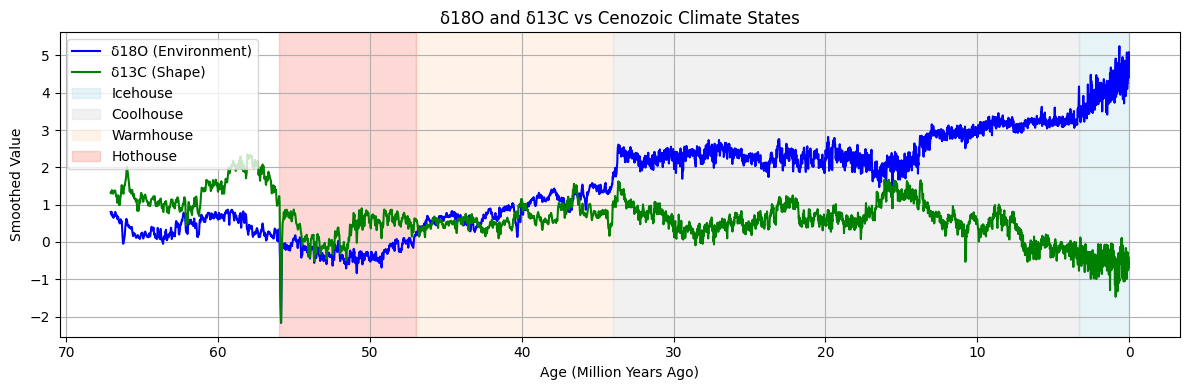

In [39]:
# Optional: If your data has time (age_tuned), you could highlight time windows
plt.figure(figsize=(12, 4))
plt.plot(df['age_tuned'], df['Env_Smooth'], label='δ18O (Environment)', color='blue')
plt.plot(df['age_tuned'], df['Shape_Smooth'], label='δ13C (Shape)', color='green')

# Shade climate states from Westerhold
plt.axvspan(0, 3.3, color='lightblue', alpha=0.3, label='Icehouse')
plt.axvspan(3.3, 34, color='lightgray', alpha=0.3, label='Coolhouse')
plt.axvspan(34, 47, color='peachpuff', alpha=0.3, label='Warmhouse')
plt.axvspan(47, 56, color='salmon', alpha=0.3, label='Hothouse')
plt.gca().invert_xaxis()
plt.legend()
plt.title('δ18O and δ13C vs Cenozoic Climate States')
plt.xlabel('Age (Million Years Ago)')
plt.ylabel('Smoothed Value')
plt.grid(True)
plt.tight_layout()
plt.show()


This plot shows how climate and biology changed over the last 70 million years.
This graph shows how the Earth's climate and life forms have changed together over time. The blue line shows climate (cold or warm), and the green line shows how life was responding. The background colors show major climate eras like warm periods and ice ages.

When the climate shifts (like around 34 million years ago, Coolhouse starts), both lines change sharply.

The blue and green lines sometimes follow each other — showing a link between environment and biological shape.